# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

## MISC

In [4]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [5]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

## Define funcs for data engi.

In [6]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [7]:
def date_flagger(data, n_steps):
    # create flag for erroneous sequences
    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [8]:
def seq_maker(data, targets, temps, dates, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    
    temps_t = temps[n_steps-t_steps:-t_steps][mask].values
    temps = temps[:-n_steps][mask].values # TEMPORARY
    
    dates = dates[:-n_steps][mask].values
    
    return sequences, targets, temps, temps_t, dates

In [9]:
def data_norm(data_train, data_test):
    col_params = {}
    for col in data_train.columns:

        min_val = data_train[col].min()
        max_val = data_train[col].max()

        # normalize
        mean = data_train[col].mean()
        std = data_train[col].std()

        data_train[col] = (data_train[col] - mean) / std
        data_test[col] = (data_test[col] - mean) / std

        col_params[col] = {
            'mean':mean,
            'std':std,
            'max':max_val,
            'min':min_val
            }
    
    return data_train, data_test, col_params

## Create func for K-fold split

In [10]:
def k_fold_data(data, k_idx, k_frac, m, cols, t_steps, n_steps, shuffle):
    
    # get days
    days = data.groupby(['month', 'day'], sort=False).count().index.values
    
    # get days for K:th fold
    train_n = int(len(days) * (1 - k_frac))
    test_n = len(days) - train_n
    
    # split days by test and train
    days_test = days[int(k_idx*test_n):int((k_idx+1)*test_n)].tolist()
    mask_test = np.array([day in days_test for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    data_train = data.loc[~mask_test].copy()
    data_test = data.loc[mask_test].copy()

    # reduce to m-min observations
    data_train, dates_train = data_reduce(data_train, m)
    data_test, dates_test = data_reduce(data_test, m)
    
#     # get dates
#     dates_train = data_train.time.date.values
#     dates_test = data_test.time.date.values
    
    # remove setpoint
    data_train[('temperatures', 'TA01_GT10X_GM10X')] -= data_train.setpoints.TA01_GT10X_GM10X + 20
    data_test[('temperatures', 'TA01_GT10X_GM10X')] -= data_test.setpoints.TA01_GT10X_GM10X + 20
    
    # filter data
    data_train = data_train[cols].copy()
    data_test = data_test[cols].copy()
    
    # normalize
    data_train, data_test, col_params = data_norm(data_train, data_test)
    
    # get targets
    targets_train = data_train.pop(('temperatures', 'TA01_GT10X_GM10X'))
    targets_test = data_test.pop(('temperatures', 'TA01_GT10X_GM10X'))
    
    # get temp info
    temps_train = targets_train.copy()
    temps_test = targets_test.copy()
    
    # create sequences    
    sequences_train, targets_train, temps_train, temps_t_train, dates_train = seq_maker(data_train, targets_train, temps_train, dates_train, n_steps)
    sequences_test, targets_test, temps_test, temps_t_test, dates_test = seq_maker(data_test, targets_test, temps_test, dates_test, n_steps)
    
    # create MASKED sequences
    sequences_masked = sequences_test.copy()
    for t in range(1, t_steps):
        sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]
    
    if shuffle:
        # shuffle training data randomly
        idxs = np.arange(len(targets_train))
        np.random.shuffle(idxs)

        sequences_train = sequences_train[idxs]
        targets_train = targets_train[idxs]
        temps_train = temps_train[idxs]
        temps_t_trian = temps_t_train[idxs]
        dates_train = dates_train[idxs]
    
    # return tups w. train and test
    train_tup = (sequences_train, targets_train, temps_train, temps_t_train, dates_train)
    test_tup = (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test)
    return train_tup, test_tup, col_params

## Create data for specific fold

In [11]:
m = 5
t_steps = 3
n_steps = 12

In [12]:
# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT401_GM401_scaled'),
    ('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    #('state', 'TA01_output'),
    #('state', 'TA02_output')
]

## Def model funcs

In [13]:
from rnn import RNN
from rmsprop import RMSProp
from adagrad import AdaGrad

In [14]:
# hyperparams
units = 128
k1 = 7
k2 = 1
T = 12
lambd = 0.01
sigma = 1.0

seed = 1
optimizer = None

In [15]:
model = RNN(
    units,
    k1,
    k2,
    T,
    seed,
    optimizer
)

adagrad = AdaGrad(
    eps=1e-6,
    weights=model.weights
)

rms_prop = RMSProp(
    beta=0.9,
    eps=1e-6,
    weights=model.weights
)

In [16]:
model.optimizer = adagrad
#model.optimizer = rms_prop

# Get sequences

In [17]:
k_idx = 8
k_frac = 0.1

# get data
train_tup, test_tup, _ = k_fold_data(
    data=data, 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    shuffle=False
)


(sequences_train, targets_train, temps_train, temps_t_train, _) = train_tup
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, _) = test_tup

In [18]:
temps_train = temps_t_train[:, np.newaxis]
targets_train = targets_train[:, np.newaxis]

In [19]:
temps_test = temps_t_test[:, np.newaxis]
targets_test = targets_test[:, np.newaxis]

## Run training w. SGD

In [20]:
n_batch = 32
lr = 0.01
n_epochs = 50

# init time step
t = 0

loss_hist = []

# create list of idxs for shuffling
idxs = list(range(len(sequences_train)))
for epoch in range(n_epochs):
    np.random.shuffle(idxs)
    sequences_train, temps_train, targets_train = sequences_train[idxs], temps_train[idxs], targets_train[idxs]
    
    for i in range(len(sequences_train) // n_batch):
        Xt_train_batch = sequences_train[i*n_batch:(i+1)*n_batch]
        Xc_train_batch = temps_train[i*n_batch:(i+1)*n_batch]
        Y_train_batch = targets_train[i*n_batch:(i+1)*n_batch]
            
        model.train(
            X_t=Xt_train_batch,
            X_c=Xc_train_batch,
            Y=Y_train_batch,
            sigma=sigma,
            lambd=lambd,
            eta=lr
        )
        
        #if t % 200 == 0:
        #    loss = model.compute_loss(X_t=sequences_train, X_c=temps_train, Y=targets_train, lambd=lambd)
        #    loss_hist.append(loss)
        #    
        #    print(epoch, t, loss)
        #    
        #t += 1
    loss = model.compute_loss(X_t=sequences_train, X_c=temps_train, Y=targets_train, lambd=lambd)
    loss_hist.append(loss)
    print(epoch, loss)

0 3.201565423883155
1 2.1322054373485124
2 1.4915060779313063
3 1.0917551099001779
4 0.8216867635977209
5 0.6451242891945077
6 0.5142400891594272
7 0.4211621445313036
8 0.3570437683870586
9 0.3026797289422729
10 0.26440009940353193
11 0.23576733109575812


KeyboardInterrupt: 

In [21]:
rnn_preds = []
rnn_encodings = []

pred_queue = deque(maxlen=t_steps)
for temp in temps_test[:t_steps]:
    pred_queue.append(temp[np.newaxis, :])
    rnn_preds.append(temp)
    
for seq in sequences_test:
    temp = pred_queue.popleft()
    temp_pred, encoded = model.predict(X_t=seq[np.newaxis, :], X_c=temp, train=False)
    pred_queue.append(temp_pred)
    rnn_preds.append(temp_pred[0])
    rnn_encodings.append(encoded[0])
    
#y_hat, encoded = model.predict(sequences_test, temps_test, train=False)

(-10.0, 10.0)

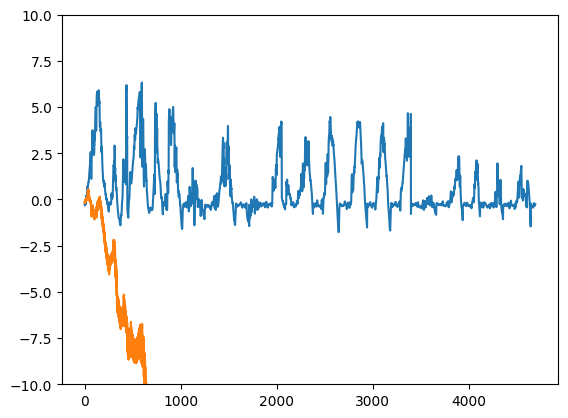

In [23]:
plt.plot(targets_test)#[-1500:])
plt.plot(rnn_preds)#[-1500:])
#plt.ylim(-10, 10)

In [23]:
from sklearn.decomposition import PCA

decomposer = PCA(n_components=2)
decomposed = decomposer.fit_transform(X=rnn_encodings)

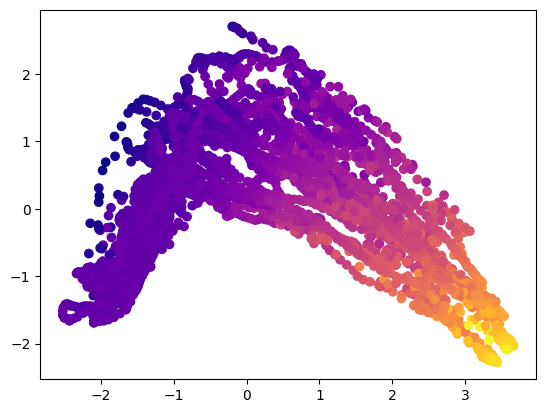

In [24]:
plt.scatter(decomposed[:, 0], decomposed[:, 1], c=temps_test, cmap='plasma')

In [25]:
test_loss = model.compute_loss(sequences_test, temps_test, targets_test, lambd=0)

In [26]:
test_loss

0.11293912608586797